<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/10-introduction-to-artificial-neural-networks-with-keras/building_dynamic_models_using_subclassing_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the Subclassing API to Build Dynamic Models

Both the Sequential API and the Functional API are declarative: you start by declaring which layers you want to use and how they should be connected, and only then can you start feeding the model some data for training or inference. 

This has many advantages: the model can easily be saved, cloned, and shared; its structure can be displayed and analyzed; the framework can infer shapes and check types, so errors can be caught early (i.e., before any data ever goes through the model). It’s also fairly easy to debug, since the whole model is a static graph of layers. 

But the flip side is just that: it’s static. Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if you prefer a more imperative programming style, the Subclassing API is for you.

Simply subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


## Load database

Let’s switch to the California housing problem and tackle it using a regression neural network. For simplicity, we will use Scikit-Learn’s fetch_california_housing() function to load the data.

After loading the data, we split it into a training set, a validation set, and a test set, and we scale all the features:

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# load dataset
housing = fetch_california_housing()

# split dataset into traing and test set 
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)

# prepare validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# scale all the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

## Build, train and evaluate the model using Subclassing API

### Handling multiple outputs by adding an auxiliary output for regularization

Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model’s ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/wide-deep-neural-network-3.JPG?raw=1' width='800'/>

Adding extra outputs is quite easy: just connect them to the appropriate layers and add them to your model’s list of outputs.

In [0]:
class WideAndDeepModel(keras.models.Model):

  def __init__(self, units=30, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.first_hidden_layer = keras.layers.Dense(units, activation=activation, name='first_hidden_layer')
    self.second_hidden_layer = keras.layers.Dense(units, activation=activation, name='second_hidden_layer')
    self.main_output_layer = keras.layers.Dense(1, name='main_output_layer')
    self.auxiliary_output_layer = keras.layers.Dense(1, name='auxiliary_output_layer')

  def call(self, inputs):
    wide_input_layer, deep_input_layer = inputs
    first_hidden_layer = self.first_hidden_layer(deep_input_layer)
    second_hidden_layer = self.second_hidden_layer(first_hidden_layer)

    concat_layer = keras.layers.concatenate([wide_input_layer, second_hidden_layer], name='concat_layer')

    main_output_layer = self.main_output_layer(concat_layer)
    auxiliary_output_layer = self.auxiliary_output_layer(second_hidden_layer)

    return main_output_layer, auxiliary_output_layer

model = WideAndDeepModel(30, activation='relu')

This extra flexibility does come at a cost: your model’s architecture is hidden within the call() method, so Keras cannot easily inspect it; it cannot save or clone it; and when you call the summary() method, you only get a list of layers, without any information on how they are connected to each other. Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. So unless you really need that extra flexibility, you should probably stick to the Sequential API or the Functional API.

In [0]:
# prepare data
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]

X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [10]:
# compile the model
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

# train the model
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
model.summary()

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 2s 175us/sample - loss: 2.4304 - output_1_loss: 2.2193 - output_2_loss: 4.3238 - val_loss: 9.8173 - val_output_1_loss: 10.3965 - val_output_2_loss: 4.5578
Epoch 2/10
11610/11610 [==============================] - 1s 68us/sample - loss: 1.0044 - output_1_loss: 0.7947 - output_2_loss: 2.8907 - val_loss: 0.9052 - val_output_1_loss: 0.6424 - val_output_2_loss: 3.2679
Epoch 3/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.7668 - output_1_loss: 0.6173 - output_2_loss: 2.1130 - val_loss: 0.8568 - val_output_1_loss: 0.5960 - val_output_2_loss: 3.2019
Epoch 4/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.6894 - output_1_loss: 0.5738 - output_2_loss: 1.7289 - val_loss: 0.8059 - val_output_1_loss: 0.5538 - val_output_2_loss: 3.0725
Epoch 5/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.6408 - output_1_loss: 

In [0]:
# evaluate the model
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test), verbose=0)

In [0]:
# make prediction
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

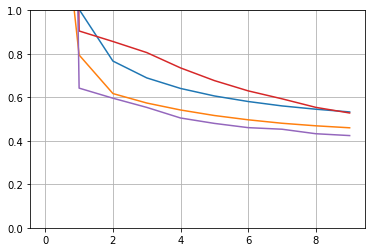

In [14]:
import pandas as pd

plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [15]:
y_pred_main

array([[0.46119922],
       [1.6560377 ],
       [3.0100455 ]], dtype=float32)

In [16]:
y_pred_aux

array([[1.2026805],
       [1.5415525],
       [2.3475633]], dtype=float32)